In [1]:
import uproot 
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

import mplhep as hep
hep.style.use('ATLAS')
from tqdm.notebook import tqdm 
from pathlib import Path

# from utils.histograms import *
from utils import compare_histograms, split_by_sr_cr, plot_ratio, getDF

In [2]:
cur_input_folder = Path("/data/hrzhao/Samples/ssWWWZ_run3/inputs_run2_combination/pos_final_v2/")
new_input_path = "/data/hrzhao/Samples/ssWWWZ_run3/information_Run2_WZHp/fit_inputs/histograms/05222024/ExportHistograms.root"
rtol_threshold = 1e-4

new_input = uproot.open(new_input_path)

In [3]:
histo_name_dict = {
    "histo_mva_sr" : "M_WZ_GMMVASR",
    "histo_mva_cr" : "M_WZ_GMMVACR", 
    "histo_zz_cr" : "M_WZ_ZZCRJJ",
}

mass_points = np.concatenate((np.arange(200, 551, 25, dtype=int), np.arange(600, 1001, 100, dtype=int)))
kfactors = [
    1.00835, 1.00869, 1.0037, 1.01429, 0.963999, 1.02804, 0.973033, 0.992546,
    0.981709, 1.01099, 1.01539, 1.09337, 1.04642, 1.21351, 1.23519, 1.26441,
    1.23159, 1.32538, 1.28826, 1.29646
]
kfactor_dict = {mass: k for mass, k in zip(mass_points, kfactors)}

# Check Data

The first is to compare the data because no k-factors is added. 

In [4]:
cur_input_path = cur_input_folder / "WZanal_Data.root"
current_input = uproot.open(cur_input_path)

sample = cur_input_path.stem.split('_')[1].lower()

In [6]:
# test_histo_keys = new_input.keys(filter_name=["GMvbf375*M_WZ_GMMVA*"], recursive=False, cycle=False)
# test_histo_keys = new_input.keys(filter_name=["data*M_WZ_GMMVA*", "data*M_WZ_ZZCRJJ"], recursive=True, cycle=False)

# test_histo_keys = new_input.keys(filter_name=["data**"], recursive=True, cycle=False)
test_histo_keys = current_input.keys(cycle=False)

In [6]:
for histo_key in test_histo_keys:
    current_histo = current_input[histo_key].to_hist()
    new_histo_name = f"{sample}_{histo_name_dict[histo_key]}"
    new_histo = new_input[new_histo_name].to_hist()

    compare_result = compare_histograms(current_histo, new_histo)

    if len(compare_result) != 0:
        print(histo_key, compare_result) 

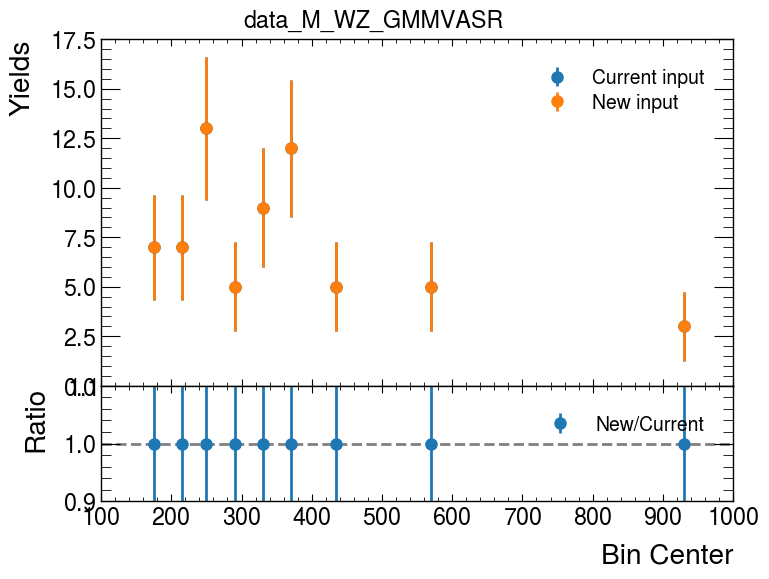

In [10]:
histo_key = test_histo_keys[0]
current_histo = current_input[histo_key].to_hist()
new_histo_name = f"{sample}_{histo_name_dict[histo_key]}"
new_histo = new_input[new_histo_name].to_hist()

fig, ax1, ax2 = plot_ratio([current_histo, new_histo], new_histo_name)
fig.savefig("./plots_input/ex_data.pdf", dpi=300)

In [17]:
df = getDF(current_histo, new_histo)
df

current_BinContent  new_BinContent  current_BinError  new_BinError
Bin1                 7.0             7.0          2.645751      2.645751
Bin2                 7.0             7.0          2.645751      2.645751
Bin3                13.0            13.0          3.605551      3.605551
Bin4                 5.0             5.0          2.236068      2.236068
Bin5                 9.0             9.0          3.000000      3.000000
Bin6                12.0            12.0          3.464102      3.464102
Bin7                 5.0             5.0          2.236068      2.236068
Bin8                 5.0             5.0          2.236068      2.236068
Bin9                 3.0             3.0          1.732051      1.732051

# Check Signal Samples

In [18]:
for mass in tqdm(mass_points):

    # open the current input file 
    cur_input_path = cur_input_folder / f"WZanal_HP{str(mass)}.root"
    assert cur_input_path.exists()
    current_input = uproot.open(cur_input_path)

    # sample = cur_input_path.stem.split('_')[1][2:]
    sample = str(mass)
    test_histo_keys = current_input.keys(cycle=False)

    for histo_key in test_histo_keys:
        region, syst = split_by_sr_cr(histo_key)
        new_histo_name = f"GMvbf{sample}_{histo_name_dict[region]}"
        if len(syst):
            # modify the new_histo_name by adding the systematics 
            # in order to find the corresponding histogram in the new root 
            new_histo_name = f"Systematics/{new_histo_name}_{syst}"

        current_histo = current_input[histo_key].to_hist()
        new_histo = new_input[new_histo_name].to_hist()

        compare_result = compare_histograms(current_histo , new_histo , rtol_threshold=1e-4, kfactor=kfactor_dict[int(sample)])
        if len(compare_result) != 0:
            print(f"Key: {histo_key}, or {new_histo_name}")
            print(f"Absolute differences in yields: {compare_result[0]}")
            print(f"Relative differences in yields: {compare_result[1]}")
            print(f"Absolute differences in variances: {compare_result[2]}")
            print(f"Relative differences in variances: {compare_result[3]}")

  0%|          | 0/20 [00:00<?, ?it/s]

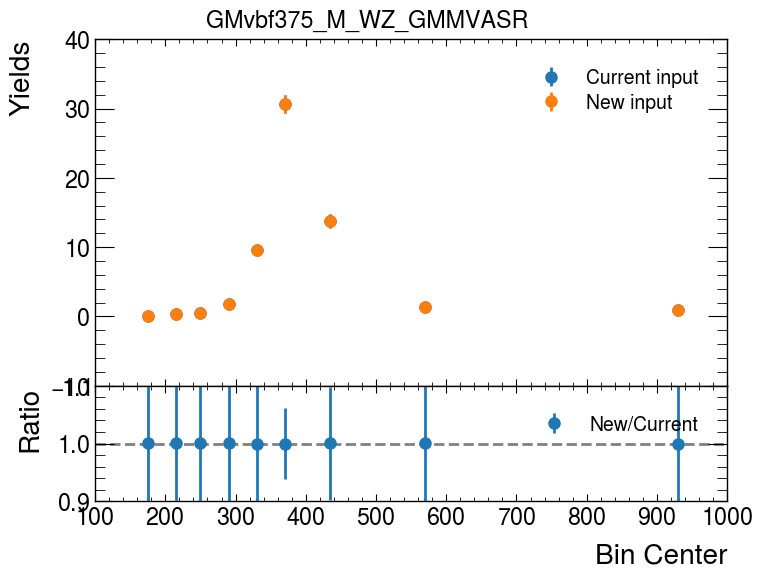

In [12]:
mass = sample = 375
cur_input_path = cur_input_folder / f"WZanal_HP{str(mass)}.root"
current_input = uproot.open(cur_input_path)
test_histo_keys = current_input.keys(cycle=False)

histo_key = test_histo_keys[0]
region, syst = split_by_sr_cr(histo_key)
current_histo = current_input[histo_key].to_hist()
new_histo_name = f"GMvbf{sample}_{histo_name_dict[region]}"
new_histo = new_input[new_histo_name].to_hist()

fig, ax1, ax2 = plot_ratio([current_histo / kfactor_dict[375], new_histo], new_histo_name)
fig.savefig("./plots_input/ex_dsig375.pdf", dpi=300)

In [31]:
df = getDF(current_histo / kfactor_dict[375], new_histo)
df

current_BinContent  new_BinContent  current_BinError  new_BinError
Bin1            0.025855        0.025855          0.042679      0.042679
Bin2            0.315558        0.315558          0.133445      0.133445
Bin3            0.540099        0.540100          0.206764      0.206764
Bin4            1.727737        1.727738          0.373687      0.373687
Bin5            9.565403        9.565402          0.713997      0.713998
Bin6           30.618779       30.618742          1.319281      1.319281
Bin7           13.775932       13.775937          0.948121      0.948121
Bin8            1.414838        1.414838          0.294866      0.294866
Bin9            0.915254        0.915254          0.170753      0.170753

# Check Background Samples 

In [13]:
bkg_names =["WZ_QCD", "WZ_EW", "ZZ", "Triboson", "FakeRenorm"]
bkg_names_newinput = ["WZQCD", "WZEW", "ZZ", "VVV", "FakeRenorm"]
sample_name_dict = {k:v for k, v in zip(bkg_names, bkg_names_newinput)}

In [32]:
for bkg_name in tqdm(bkg_names):
    print(f"Processing Sample: {bkg_name}")
    cur_input_path = cur_input_folder / f"WZanal_{bkg_name}.root"
    assert cur_input_path.exists()
    current_input = uproot.open(cur_input_path)

    test_histo_keys = current_input.keys(cycle=False)

    for histo_key in test_histo_keys:
        region, syst = split_by_sr_cr(histo_key)
        new_histo_name = f"{sample_name_dict[bkg_name]}_{histo_name_dict[region]}"
        if len(syst):
            # modify the new_histo_name by adding the systematics 
            # in order to find the corresponding histogram in the new root 
            new_histo_name = f"Systematics/{new_histo_name}_{syst}"
        current_histo = current_input[histo_key].to_hist()
        new_histo = new_input[new_histo_name].to_hist()

        compare_result = compare_histograms(current_histo , new_histo , rtol_threshold=1e-4)
        if len(compare_result) != 0:
            print(f"Key: {histo_key}, or {new_histo_name}")
            print(f"Absolute differences in yields: {compare_result[0]}")
            print(f"Relative differences in yields: {compare_result[1]}")
            print(f"Absolute differences in variances: {compare_result[2]}")
            print(f"Relative differences in variances: {compare_result[3]}")


  0%|          | 0/5 [00:00<?, ?it/s]

Processing Sample: WZ_QCD
Processing Sample: WZ_EW
Processing Sample: ZZ
Processing Sample: Triboson
Processing Sample: FakeRenorm
Key: histo_mva_srFF_fakeCRStats__1up, or Systematics/FakeRenorm_M_WZ_GMMVASR_FF_fakeCRStats__1up
Absolute differences in yields: [2.78814696e-07 3.53902578e-07 5.30388206e-07 0.00000000e+00
 1.07334927e-07 1.29512046e-07 1.05763320e-07 0.00000000e+00
 3.35603545e-09]
Relative differences in yields: [0.00016593 0.0001659  0.000166   0.         0.000166   0.00016597
 0.00016585 0.         0.00016587]
Absolute differences in variances: [1.63354233e-07 1.88706068e-07 2.75975845e-07 0.00000000e+00
 7.58758616e-08 1.29489445e-07 9.80612093e-08 0.00000000e+00
 3.35790682e-09]
Relative differences in variances: [0.00016596 0.0001659  0.00016593 0.         0.00016593 0.00016595
 0.0001659  0.         0.00016597]


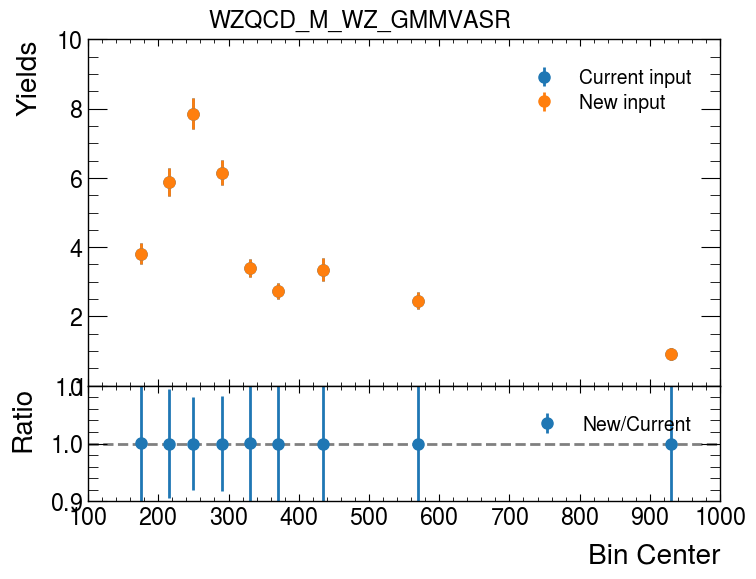

In [14]:
bkg_name = bkg_names[0]
cur_input_path = cur_input_folder / f"WZanal_{bkg_name}.root"
current_input = uproot.open(cur_input_path)

test_histo_keys = current_input.keys(cycle=False)
histo_key = test_histo_keys[0]

region, syst = split_by_sr_cr(histo_key)
new_histo_name = f"{sample_name_dict[bkg_name]}_{histo_name_dict[region]}"
if len(syst):
    # modify the new_histo_name by adding the systematics 
    # in order to find the corresponding histogram in the new root 
    new_histo_name = f"Systematics/{new_histo_name}_{syst}"
current_histo = current_input[histo_key].to_hist()
new_histo = new_input[new_histo_name].to_hist()

fig, ax1, ax2 = plot_ratio([current_histo, new_histo], new_histo_name)
fig.savefig("./plots_input/ex_bkgWZCD.pdf", dpi=300)

In [35]:
df = getDF(current_histo, new_histo)
df

current_BinContent  new_BinContent  current_BinError  new_BinError
Bin1            3.807675        3.807677          0.301726      0.301726
Bin2            5.878044        5.878043          0.393695      0.393695
Bin3            7.848063        7.848060          0.442636      0.442636
Bin4            6.144414        6.144413          0.359667      0.359667
Bin5            3.394611        3.394613          0.268499      0.268499
Bin6            2.735760        2.735760          0.236000      0.236000
Bin7            3.351044        3.351042          0.341062      0.341062
Bin8            2.458906        2.458906          0.244736      0.244736
Bin9            0.907031        0.907031          0.172737      0.172737